# 1.对文件进行分类

In [1]:
import os
import shutil

import torch.cuda
from scipy.odr import exponential
from sklearn.model_selection import train_test_split


def data_restoration(data_path, is_valid=True):
    """
    这个函数的作用是将data_path这个路径中已经划分好训练集测试机的图像文件，重新汇总到一个文件夹中，
    汇总后的原文件夹仍保留原有分类，以方便重新的训练集测试集划分。
    :param data_path:已划分完成的数据文件家路径。
    :param is_valid:是否存在验证集。
    :return:
    """
    # 移动test文件夹
    for file_folder in os.listdir(os.path.join(data_path, 'test')):
        os.makedirs(os.path.join(data_path, file_folder), exist_ok=True)
        for img_file in os.listdir(os.path.join(data_path, 'test', file_folder)):
            shutil.move(os.path.join(data_path, 'test', file_folder, img_file),
                        os.path.join(data_path, file_folder, img_file))
    # 移动train文件夹
    for file_folder in os.listdir(os.path.join(data_path, 'train')):
        for img_file in os.listdir(os.path.join(data_path, 'train', file_folder)):
            shutil.move(os.path.join(data_path, 'train', file_folder, img_file),
                        os.path.join(data_path, file_folder, img_file))
    if is_valid:
        for file_folder in os.listdir(os.path.join(data_path, 'valid')):
            for img_file in os.listdir(os.path.join(data_path, 'valid', file_folder)):
                shutil.move(os.path.join(data_path, 'valid', file_folder, img_file),
                            os.path.join(data_path, file_folder, img_file))

    shutil.rmtree(os.path.join(data_path, 'test'))
    shutil.rmtree(os.path.join(data_path, 'train'))
    if is_valid:
        shutil.rmtree(os.path.join(data_path, 'valid'))


def training_set_division(data_path, test_size=0.2, is_valid=True, valid_size=0.2):
    """
    对于原始已分好类的数据文件夹进行训练集,验证集和测试集.
    :param data_path: 文件夹路径
    :param test_size: 测试集占原数据集的比例
    :param is_valid: 是否划分验证集，默认进行划分
    :param valid_size: 验证集占非测试集数据的比例
    :return:
    """
    file_folders = os.listdir(data_path)

    # 创建训练集，测试集文件夹
    test_path = os.path.join(data_path, 'test')
    train_path = os.path.join(data_path, 'train')
    os.makedirs(test_path)
    os.makedirs(train_path)

    # 创建验证集文件夹
    if is_valid:
        valid_path = os.path.join(data_path, 'valid')
        os.makedirs(valid_path)

    for file_folder in file_folders:

        # 获得路径
        current_folder_path = os.path.join(data_path, file_folder)
        img_ids = os.listdir(current_folder_path)
        current_train_folder_path = os.path.join(train_path, file_folder)
        current_test_folder_path = os.path.join(test_path, file_folder)

        # 创建训练集，测试集子文件夹
        os.makedirs(current_train_folder_path, exist_ok=True)
        os.makedirs(current_test_folder_path, exist_ok=True)

        # 创建验证集子文件夹
        if is_valid:
            current_valid_folder_path = os.path.join(valid_path, file_folder)
            os.makedirs(current_valid_folder_path, exist_ok=True)

        # 划分测试集训练集
        train_ids, test_ids = train_test_split(img_ids, test_size=test_size)

        # 移动文件
        for train_id in train_ids:
            shutil.move(os.path.join(current_folder_path, train_id), os.path.join(current_train_folder_path, train_id))
        for test_id in test_ids:
            shutil.move(os.path.join(current_folder_path, test_id), os.path.join(current_test_folder_path, test_id))

        # 移动训练集文件
        if is_valid:
            train_ids, valid_ids = train_test_split(train_ids, test_size=valid_size)
            for valid_id in valid_ids:
                shutil.move(os.path.join(current_train_folder_path, valid_id),
                            os.path.join(current_valid_folder_path, valid_id))

        # 删除原有文件夹
        shutil.rmtree(current_folder_path)


data_restoration('data')
training_set_division('data')

# 2.构建数据集

In [1]:
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os


# 创建我的图像数据集类
class MyPilDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(self.root_dir))

        for idx, class_name in enumerate(self.class_names):
            self.class_to_idx[class_name] = idx
            for file in os.listdir(os.path.join(self.root_dir, class_name)):
                self.img_paths.append(os.path.join(self.root_dir, class_name, file))
                self.labels.append(idx)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, item):
        img = Image.open(self.img_paths[item]).convert('RGB')
        label = self.labels[item]
        img = self.transform(img)
        return img, label


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# 创建图像变化
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.Normalize(mean=mean, std=std)
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
transform_denormalize = transforms.Compose([
    transforms.Normalize(mean=-mean / std, std=1 / std),
    transforms.ToPILImage()
])

# 构建数据集
train_dataset = MyPilDataset('data/train', transform=train_transform)
test_dataset = MyPilDataset('data/test', transform=test_transform)
valid_dataset = MyPilDataset("data/valid", transform=test_transform)

# 构建数据装载器
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# 3.构建模型

In [2]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict


class MyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 采用resnet18预训练网络
        self.model = models.resnet18(pretrained=True)
        # 冻结参数，防止训练时间过长
        for para in self.model.parameters():
            para.requires_grad = False
        # 修改网络最后的分类部分
        self.model.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=512, out_features=256)),
            ('relu', nn.ReLU(inplace=True)),
            ('linear2', nn.Linear(in_features=256, out_features=num_classes))
        ]))

    def forward(self, x):
        return self.model(x)

    def __call__(self, x):
        return self.forward(x)


model = MyModel(len(train_dataset.class_names))

D:\anaconda\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 4.训练网络

In [6]:
import torch.optim as optim
import torch


def model_training(model, train_dataloader, valid_dataloader=None, lr=0.01, num_epochs=10,
                   device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    model.to(device)
    best_accuracy = 0
    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        train_total_loss = 0
        valid_total_loss = 0
        train_accuracy = 0
        valid_accuracy = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_accuracy += (predicted == labels).sum().item()

        if valid_dataloader is not None:
            model.eval()
            with torch.no_grad():
                for images, labels in valid_dataloader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    valid_total_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    valid_accuracy += (predicted == labels).sum().item()

            valid_accuracy /= len(valid_dataloader.dataset)
            valid_total_loss /= len(valid_dataloader)
        train_total_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader.dataset)
        print(f"第{epoch + 1}轮：训练集损失:{train_total_loss:.3f},训练集正确率：{train_accuracy * 100:.2f}%."
              f"验证集损失：{valid_total_loss:.3f},验证集正确率：{valid_accuracy * 100:.2f}%")
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), 'best_model.pth')


model_training(model, train_dataloader, valid_dataloader=valid_dataloader, num_epochs=25)


True
第1轮：训练集损失:0.666,训练集正确率：78.17%.验证集损失：0.277,验证集正确率：91.65%
第2轮：训练集损失:0.322,训练集正确率：90.33%.验证集损失：0.268,验证集正确率：92.39%
第3轮：训练集损失:0.330,训练集正确率：90.81%.验证集损失：0.268,验证集正确率：92.15%
第4轮：训练集损失:0.284,训练集正确率：91.03%.验证集损失：0.212,验证集正确率：93.99%
第5轮：训练集损失:0.284,训练集正确率：91.43%.验证集损失：0.196,验证集正确率：94.44%
第6轮：训练集损失:0.265,训练集正确率：91.66%.验证集损失：0.201,验证集正确率：94.39%
第7轮：训练集损失:0.276,训练集正确率：91.81%.验证集损失：0.197,验证集正确率：94.32%
第8轮：训练集损失:0.282,训练集正确率：91.83%.验证集损失：0.205,验证集正确率：94.51%
第9轮：训练集损失:0.260,训练集正确率：92.11%.验证集损失：0.213,验证集正确率：94.35%
第10轮：训练集损失:0.273,训练集正确率：91.81%.验证集损失：0.215,验证集正确率：94.27%
第11轮：训练集损失:0.265,训练集正确率：91.95%.验证集损失：0.233,验证集正确率：93.73%
第12轮：训练集损失:0.268,训练集正确率：92.08%.验证集损失：0.229,验证集正确率：93.70%
第13轮：训练集损失:0.265,训练集正确率：92.15%.验证集损失：0.201,验证集正确率：93.96%
第14轮：训练集损失:0.262,训练集正确率：92.02%.验证集损失：0.225,验证集正确率：93.58%
第15轮：训练集损失:0.271,训练集正确率：91.96%.验证集损失：0.272,验证集正确率：92.60%


KeyboardInterrupt: 

# 5.装载模型

In [10]:
model.load_state_dict(torch.load('best_model.pth'))

MyModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

# 6.测试模型

In [17]:
import numpy as np


def test_model(model, test_dataloader):
    """
    对网络进行测试。
    :param model:待测试的模型
    :param test_dataloader:训练文件装载器
    :return:
    """
    model.eval()
    test_accuracy = 0
    test_loss = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    # 将数据导入网络
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, 1)

            test_accuracy += (predicted == labels).sum().item()
            test_loss += loss.item()

        test_accuracy /= len(test_dataloader.dataset)
        test_loss /= len(test_dataloader)
        print(f'测试集的平均损失是{test_loss:.3f},测试集的正确率是{test_accuracy * 100:.2f}%.')
        print(f'模型在测试集上正确类别的平均概率为{np.exp(-test_loss) * 100:.2f}%')


test_model(model, test_dataloader)

测试集的平均损失是0.226,测试集的正确率是93.67%.
模型在测试集上正确类别的平均概率为79.78%


# 7.从网上随便选取图片进行测试

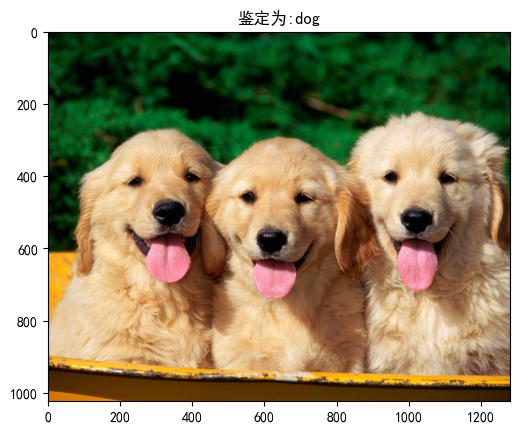

In [41]:
import matplotlib.pyplot as plt

# 解决字体显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

test_image = Image.open('R.jpg')
# 将测试图像转化为模型能够识别的形式
test_image = test_transform(test_image).unsqueeze(0).to(torch.device('cuda'))
output = model(test_image)

# 将输出转化为类别
predicted = torch.softmax(output, 1).to(torch.device('cpu'))
predicted = predicted.detach().numpy()
test_image = Image.open('R.jpg')
plt.figure(1)
plt.title(f'鉴定为:{train_dataset.class_names[np.argmax(predicted)]}')
plt.imshow(test_image)
plt.savefig("鉴定结果")
plt.show()